In [18]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pylab as pl
from IPython import display
from parameters import *
from micro import *
from aero_init import *
from parcel import *
from condensation import *
from collision import *
from analysis import *
from print_plot import *
from animation import *

import itertools
import matplotlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intialization
## Input parameter

In [19]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create the widgets for the variables
dt_widget      = widgets.BoundedFloatText(description='dt [s]:', min = 0.0001, max = 5.0, value = 0.5)
nt_widget      = widgets.IntText(description='nt:', value = 3600)

Condensation_widget = widgets.Checkbox(description='Condensation:', value=True)
Collision_widget = widgets.Checkbox(description='Collision:', value=False)

n_particles_widget = widgets.BoundedIntText(description='n_particles:', min=500, max=1000, value=500)
n_particles_slider = widgets.IntSlider(description=' ', min=500, max=1000, value=500)
# link slider and textbox
mylink = widgets.jslink((n_particles_widget, 'value'), (n_particles_slider, 'value'))

collision_start_t_widget = widgets.BoundedIntText(description='collision start time [s]:', min = 0,max=10000,value = 0)

# max z insert again
max_z_widget = widgets.BoundedFloatText(description='z_max [m]:', min = 0.0, max = 1400.0, step = 0.1, value=1500.0)
# max value of collision_start_t_widget not updated when nt changed in the textbox! It remains at the default value of nt_widget

# Display the widgets
display('Model steering parameters',dt_widget, nt_widget, Condensation_widget,Collision_widget, n_particles_widget, n_particles_slider, \
        collision_start_t_widget, max_z_widget) #button)

'Model steering parameters'

BoundedFloatText(value=0.5, description='dt [s]:', max=5.0, min=0.0001)

IntText(value=3600, description='nt:')

Checkbox(value=True, description='Condensation:')

Checkbox(value=False, description='Collision:')

BoundedIntText(value=500, description='n_particles:', max=1000, min=500)

IntSlider(value=500, description=' ', max=1000, min=500)

BoundedIntText(value=0, description='collision start time [s]:', max=10000)

BoundedFloatText(value=1400.0, description='z_max [m]:', max=1400.0, step=0.1)

In [20]:
# section for widgets for parcel info
T_widget = widgets.BoundedFloatText(description='T [K]:', min = 200.0, max = 320.0, step = 0.1, value=293.2)
P_widget = widgets.BoundedFloatText(description='P [Pa]:', min = 950.0E2, max = 1050.0E2, step = 1, value=1013.0E2)
RH_widget= widgets.BoundedFloatText(description='RH [-]:', min = 0.01, max = 0.99, step = 0.01, value=0.88)
w_widget = widgets.BoundedFloatText(description='w [m/s]:', min = 0.0, max = 10, step = 0.1, value=0.5)


# Display widgets
display('Parcel initial parameters: ', T_widget, P_widget, RH_widget, w_widget)

'Parcel initial parameters: '

BoundedFloatText(value=293.2, description='T [K]:', max=320.0, min=200.0, step=0.1)

BoundedFloatText(value=101300.0, description='P [Pa]:', max=105000.0, min=95000.0, step=1.0)

BoundedFloatText(value=0.88, description='RH [-]:', max=0.99, min=0.01, step=0.01)

BoundedFloatText(value=0.5, description='w [m/s]:', max=10.0, step=0.1)

In [21]:
# user can choice the ascending mode
ascending_mode_widget = widgets.ToggleButtons(options=['linear', 'sine', 'in_cloud_oscillation'], value='linear', description='ascending', layout={'width': 'max-content'}, disabled=False)
display('ascending mode: ', ascending_mode_widget)
# maybe include more advanced ascending modes later

'ascending mode: '

ToggleButtons(description='ascending', layout=Layout(width='max-content'), options=('linear', 'sine', 'in_clou…

In [22]:
# widgets for aerosol initialisation
mode_aero_init_widget = widgets.ToggleButtons(options=['weighting_factor', 'random'], value='weighting_factor', description='mode of aerosol init.:', layout={'width': 'max-content'}, disabled=False)

# Display widgets
display('Aerosol initialisation: ', mode_aero_init_widget)

'Aerosol initialisation: '

ToggleButtons(description='mode of aerosol init.:', layout=Layout(width='max-content'), options=('weighting_fa…

In [23]:
# N, mu, sigma for each mode
# widgets in GridspecLayout
# see: https://ipywidgets.readthedocs.io/en/latest/examples/Layout%20Templates.html#style-attributes
print('Please insert the parameters for each mode (=row). If you only want e.g. 2 modes, leave the last two rows empty')
print('Click on the heading buttons to plot the distributions of the respective modes.')
print('N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu')

gridwidget = widgets.GridspecLayout(4, 4)

# work in progress, values not yet adapted
# col 0 for mode 1
gridwidget[0, 0]= widgets.Button(description='Mode #1 (plot)', disabled=False, button_style='info', tooltip='Heading')
# idea: print distribution on clicking
# see: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#button
gridwidget[1, 0] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=1000.0)
# internally multiply this by 1E6
gridwidget[2, 0] = widgets.BoundedFloatText(description='mu [µm]', min = 0.0, max = 5.0, step = 0.001, value=0.008)
# internally multiply this by 1E-6 and take the log
gridwidget[3, 0] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=1.6)
# internally take the log

# col 1 for mode 2
gridwidget[0, 1]= widgets.Button(description='Mode #2 (plot)', disabled=False, button_style='info', tooltip='Heading')

gridwidget[1, 1] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=800.0)
# internally multiply this by 1E6
gridwidget[2, 1] = widgets.BoundedFloatText(description='mu [µm]', min = 0.0, max = 5.0, step = 0.001, value=0.034)
# internally multiply this by 1E-6 and take the log
gridwidget[3, 1] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=2.1)
# internally take the log

# col 2 for mode 3
gridwidget[0, 2]= widgets.Button(description='Mode #3 (plot)', disabled=False, button_style='info', tooltip='Heading')

gridwidget[1, 2] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.01, value=0.72)
# internally multiply this by 1E6
gridwidget[2, 2] = widgets.BoundedFloatText(description='mu [µm]', min = 0.0, max = 5.0, step = 0.1, value=0.46)
# internally multiply this by 1E-6 and take the log
gridwidget[3, 2] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=2.2)
# internally take the log


# col 3 for mode 4
gridwidget[0, 3]= widgets.Button(description='Mode #4 (plot)', disabled=False, button_style='info', tooltip='Heading')

gridwidget[1, 3] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=0)
# internally multiply this by 1E6
gridwidget[2, 3] = widgets.BoundedFloatText(description='mu [µm]', min = 0.0, max = 5.0, step = 0.1, value=0)
# internally multiply this by 1E-6 and take the log
gridwidget[3, 3] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=0)
# internally take the log


# additional button in the end for the cumulative distr.
plotbutton_widget = widgets.Button(description='Plot cumulative distr.', disabled=False, button_style='info', tooltip='Plot cumulative distribution of all modes')

display(gridwidget, plotbutton_widget)

Please insert the parameters for each mode (=row). If you only want e.g. 2 modes, leave the last two rows empty
Click on the heading buttons to plot the distributions of the respective modes.
N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu


GridspecLayout(children=(Button(button_style='info', description='Mode #1 (plot)', layout=Layout(grid_area='wi…

Button(button_style='info', description='Plot cumulative distr.', style=ButtonStyle(), tooltip='Plot cumulativ…

In [24]:
# model steering parameters as read in above
dt = dt_widget.value #0.5
nt = nt_widget.value #100

do_condensation = Condensation_widget.value  #True
do_collision    = Collision_widget.value  #False

collision_start_time = collision_start_t_widget.value
n_particles = n_particles_widget.value

#parcel info. 
T_parcel   = T_widget.value
P_parcel   = P_widget.value
RH_parcel  = RH_widget.value
w_parcel   = w_widget.value
z_parcel   = 0.0 #m

# RH to q conversion
q_parcel    = RH_parcel * esatw( T_parcel ) / ( P_parcel - RH_parcel * esatw( T_parcel ) ) * r_a / rv

# new: max_z now depends on collision_start_time and w_parcel
# => strange results if collision_start_time is quite small
# changed back to manual max_z initialization
# max_z = collision_start_time * w_parcel 

max_z = max_z_widget.value

#aerosol initialization
mode_aero_init = mode_aero_init_widget.value  # "weighting_factor", 'random'

# read in the variables given above taking into account unit factors
N_aero     = [gridwidget[1, 0].value*1.0E6, gridwidget[1, 1].value*1.0E6, gridwidget[1, 2].value*1.0E6, gridwidget[1, 3].value*1.0E6]
mu_aero    = [gridwidget[2, 0].value*1.0E-6, gridwidget[2, 1].value*1.0E-6, gridwidget[2, 2].value*1.0E-6, gridwidget[2, 3].value*1.0E-6]
sigma_aero = [gridwidget[3, 0].value, gridwidget[3, 1].value, gridwidget[3, 2].value, gridwidget[3, 3].value]

# truncate the array before taking the log if one of the N_aero_i is 0, which means that this will no longer be used
N_aero_array = np.array(N_aero) # first: convert into np.array
zeroindices  = np.where(N_aero_array==0) # get the number of ther mode which is empty
zeroindices  = zeroindices[0]       # some conversion for better usage

# conversion of the other indices
mu_aero_array = np.array(mu_aero)
sigma_aero_array = np.array(sigma_aero)

# now delete the respective item in each array (N, mu, sigma)
if len(zeroindices) > 0:
    # delete
    N_aero_array     = np.delete(N_aero_array, zeroindices)
    mu_aero_array    = np.delete(mu_aero_array, zeroindices)
    sigma_aero_array = np.delete(sigma_aero_array, zeroindices)

# now perform the log of the mu and the sigma arrays
mu_aero_array = np.log(mu_aero_array)
sigma_aero_array = np.log(sigma_aero_array)

# renaming
N_aero = N_aero_array
mu_aero = mu_aero_array
sigma_aero = sigma_aero_array
    
# if (any of the ) N_aero == 0 --> error, it should not start

# Time step routine

In [29]:
# setting of display mode while running: either output of variables in text form (fast, recommended) = 'text'
# or: continuously updated plot using plotly (slow, time & memory consuming) = 'graphics'
mode_displaytype_widget = widgets.ToggleButtons(options=['text_fast', 'graphics_slow'], value='text_fast', description='display mode:', layout={'width': 'max-content'}, disabled=False)
display(mode_displaytype_widget)

ToggleButtons(description='display mode:', layout=Layout(width='max-content'), options=('text_fast', 'graphics…

In [31]:
dz=0
rho_parcel, V_parcel, air_mass_parcel =  parcel_rho(P_parcel, T_parcel)
#Aerosol init
T_parcel, q_parcel, particles_list = aero_init(mode_aero_init, n_particles, P_parcel, T_parcel,q_parcel, N_aero, mu_aero,sigma_aero,rho_aero,molecular_weight_aero)
#parcel routine
#initalize spectrum output
spectra_arr = np.zeros((nt+1,len(rm_spec)))
# init of array for time series output
qa_ts,qc_ts,qr_ts = np.zeros(nt+1),np.zeros(nt+1),np.zeros(nt+1)
na_ts,nc_ts,nr_ts = np.zeros(nt+1),np.zeros(nt+1),np.zeros(nt+1)

spectra_arr[0],qa_ts[0], qc_ts[0],qr_ts[0], na_ts[0], nc_ts[0], nr_ts[0] = qc_qr_analysis(particles_list,air_mass_parcel,rm_spec, n_bins)

# init of array for T_parcel, RH_parcel, q_parcel and z_parcel values for each timestep
T_parcel_array  = np.zeros(nt+1)
RH_parcel_array = np.zeros(nt+1)
q_parcel_array  = np.zeros(nt+1)
z_parcel_array  = np.zeros(nt+1)


# inserting the init. values to the 0th position of the arrays
T_parcel_array[0]  = T_parcel
RH_parcel_array[0] = (q_parcel * P_parcel / (q_parcel + r_a / rv)) / esatw( T_parcel ) 
q_parcel_array[0]  = q_parcel
z_parcel_array[0]  = z_parcel

ascending_mode=ascending_mode_widget.value
time_half_wave_parcel = 600.0

# read in display mode
display_mode = mode_displaytype_widget.value

if display_mode == 'graphics_slow':
    # initialization of animation
    figure_item = animation_init(dt, nt,rm_spec, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array)


for t in range(nt):
    time = (t+1)*dt
    #Parcel ascending
    #if z_parcel < max_z: 
    z_parcel, T_parcel, rho_parcel, V_parcel, air_mass_parcel = ascend_parcel(z_parcel, T_parcel,P_parcel, w_parcel, dt, time, time_half_wave_parcel, ascending_mode, max_z)
    
    #Condensational Growth
    dq_liq = 0.0
    if do_condensation:
        particles_list, T_parcel, q_parcel = drop_condensation(particles_list, T_parcel, q_parcel, P_parcel, dt, air_mass_parcel, rho_aero, molecular_weight_aero)

    #Collisional Growth
    if do_collision and time > collision_start_time:
        particles_list = collection(dt, particles_list,rho_parcel, rho_liq, P_parcel, T_parcel)
    #Analysis
    spectra_arr[t+1],qa_ts[t+1], qc_ts[t+1],qr_ts[t+1], na_ts[t+1], nc_ts[t+1], nr_ts[t+1] = qc_qr_analysis(particles_list,air_mass_parcel,rm_spec, n_bins)
    RH_parcel = (q_parcel * P_parcel / (q_parcel + r_a / rv)) / esatw( T_parcel ) 
    
    # saving of T_parcel, RH_parcel, q_parcel, z_parcel for every timestep (needed for plots)
    T_parcel_array[t+1]  = T_parcel
    RH_parcel_array[t+1] = RH_parcel
    q_parcel_array[t+1]  = q_parcel
    z_parcel_array[t+1]  = z_parcel
    
    time_array = np.arange(nt+1)*dt

    #Visulaization at every second
    if (time%1) ==0:
        if display_mode == 'graphics_slow':
            # function to draw and update the plotly figure
            animation_call(figure_item, time_array, dt, nt,rm_spec, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array)
        else:
            print_output(t,dt, z_parcel, T_parcel, q_parcel, RH_parcel, qc_ts[t+1], qr_ts[t+1], na_ts[t+1], nc_ts[t+1], nr_ts[t+1])
    #spec_plot(ax,spectra_arr, nt, log_edges)
    

ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'label'

Did you mean "line"?

    Valid properties:
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            :class:`plotly.graph_objects.scatter.ErrorX` instance
            or dict with compatible properties
        error_y
            :class:`plotly.graph_objects.scatter.ErrorY` instance
            or dict with compatible properties
        fill
            Sets the area to fill with a solid color. Defaults to
            "none" unless this trace is stacked, then it gets
            "tonexty" ("tonextx") if `orientation` is "v" ("h") Use
            with `fillcolor` if not "none". "tozerox" and "tozeroy"
            fill to x=0 and y=0 respectively. "tonextx" and
            "tonexty" fill between the endpoints of this trace and
            the endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like "tozerox" and "tozeroy". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. "tonext" fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            "toself" if there is no trace before it. "tonext"
            should not be used if one trace does not enclose the
            other. Traces in a `stackgroup` will only fill to (or
            be filled to) other traces in the same group. With
            multiple `stackgroup`s or some traces stacked and some
            not, if fill-linked traces are not already consecutive,
            the later ones will be pushed down in the drawing
            order.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        fillpattern
            Sets the pattern within the marker.
        groupnorm
            Only relevant when `stackgroup` is used, and only the
            first `groupnorm` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the normalization for the sum of
            this `stackgroup`. With "fraction", the value of each
            trace at each location is divided by the sum of all
            trace values at that location. "percent" is the same
            but multiplied by 100 to show percentages. If there are
            multiple subplots, or multiple `stackgroup`s on one
            subplot, each will be normalized within its own set.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.scatter.Hoverlabel`
            instance or dict with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is "toself" or "tonext" and there
            are no markers or text, then the default is "fills",
            otherwise it is "points".
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scatter.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        line
            :class:`plotly.graph_objects.scatter.Line` instance or
            dict with compatible properties
        marker
            :class:`plotly.graph_objects.scatter.Marker` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        orientation
            Only relevant when `stackgroup` is used, and only the
            first `orientation` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the stacking direction. With "v"
            ("h"), the y (x) values of subsequent traces are added.
            Also affects the default value of `fill`.
        selected
            :class:`plotly.graph_objects.scatter.Selected` instance
            or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stackgaps
            Only relevant when `stackgroup` is used, and only the
            first `stackgaps` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Determines how we handle locations at
            which other traces in this group have data but this one
            does not. With *infer zero* we insert a zero at these
            locations. With "interpolate" we linearly interpolate
            between existing values, and extrapolate a constant
            beyond the existing values.
        stackgroup
            Set several scatter traces (on the same subplot) to the
            same stackgroup in order to add their y values (or
            their x values if `orientation` is "h"). If blank or
            omitted this trace will not be stacked. Stacking also
            turns `fill` on by default, using "tonexty" ("tonextx")
            if `orientation` is "h" ("v") and sets the default
            `mode` to "lines" irrespective of point count. You can
            only stack on a numeric (linear or log) axis. Traces in
            a `stackgroup` will only fill to (or be filled to)
            other traces in the same group. With multiple
            `stackgroup`s or some traces stacked and some not, if
            fill-linked traces are not already consecutive, the
            later ones will be pushed down in the drawing order.
        stream
            :class:`plotly.graph_objects.scatter.Stream` instance
            or dict with compatible properties
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            `textposition`.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `texttemplate`.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.scatter.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        
Did you mean "line"?

Bad property path:
label
^^^^^

In [10]:
# user can choice if he wants the plots time-dependent or height-dependent (except of DSD and particle densities always being time dependent)
mode_plots_widget = widgets.ToggleButtons(options=['time-series', 'vertical profile'], value='time-series', description='plots are:', layout={'width': 'max-content'}, disabled=False)
display(mode_plots_widget)

ToggleButtons(description='plots are:', layout=Layout(width='max-content'), options=('time-series', 'vertical …

/project/meteo/work/Julian.HumerHager/Hiwi_Clouds/PyLCM_parcel/print_plot.py:23: UserWarning:

Log scale: values of z <= 0 have been masked



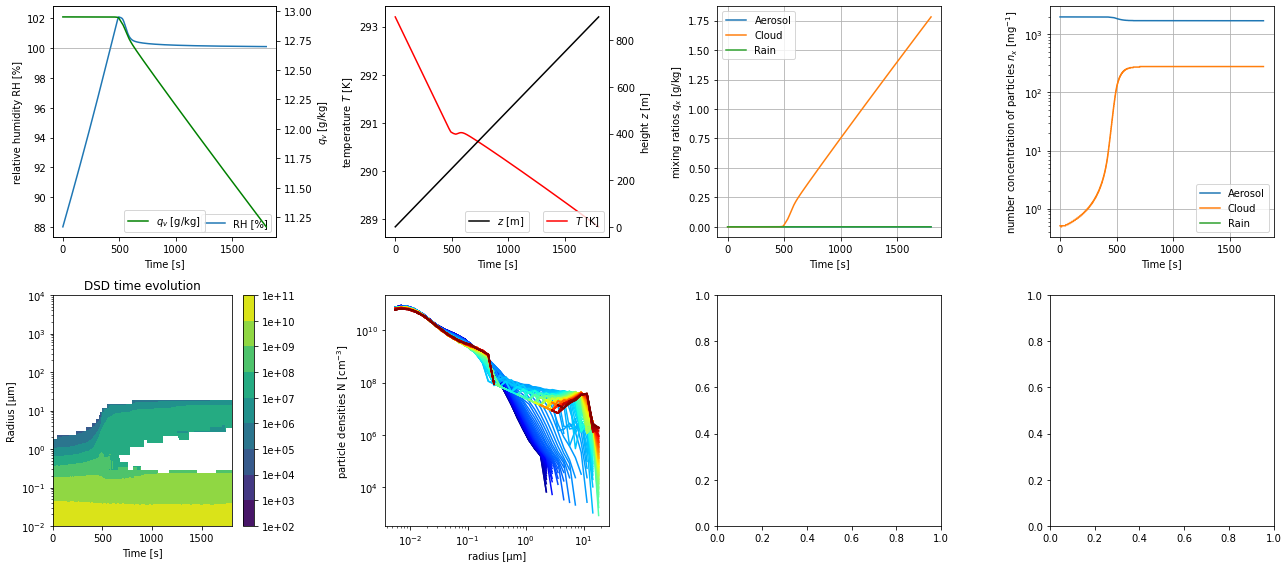

In [11]:
plot_mode=mode_plots_widget.value
subplot_array_function(plot_mode, dt, nt,rm_spec, qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, T_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, spectra_arr)

## Test area for array combination and saving

In [127]:
# save array of output variables into csv-file, optional filename can be given as filename='my_filename.csv'
save_model_output_variables(time_array, RH_parcel_array, q_parcel_array, T_parcel_array, z_parcel_array, qa_ts, \
                            qc_ts, qr_ts, na_ts, nc_ts, nr_ts, filename='testoutput_model2.csv')

Output data written to: output/testoutput_model2.csv


In [23]:
# save array of DSD spectra per timesteps, combined with radii to csv-file
save_model_output_dsd(spectra_arr, rm_spec, rl_spec, rr_spec, nt, filename='dsd_array_output_check_newlayout_2.csv')

Output data of droplet size distribution written to: output/dsd_array_output_check_newlayout_2.csv


## Test area for plot development
This could be a question / homework exercise

In [20]:
np.diff(T_parcel_array) / np.diff(z_parcel_array)

array([-0.00976122, -0.00976122, -0.00976122, ..., -0.00342517,
       -0.00343025, -0.00345568])

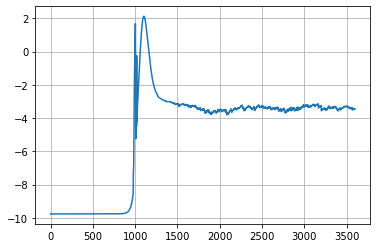

In [21]:
# test plot of the temperature gradient vs time K per km
plt.plot((np.diff(T_parcel_array) / np.diff(z_parcel_array))[1:nt+1]*1000)
plt.grid()